# NextGenAICamp: Audio Classification (ประมวลผลแล้วจำแนกเสียง) ด้วย ESC-50 dataset (ชุดข้อมูลเสียงจากสภาพแวดล้อม 50 แบบ)

\
จัดทำโดย Halemo GPA https://www.kaggle.com/code/halemogpa/audio-classification-esc-50-pytorch-cnn \\
เรียบเรียง เพิ่มเติม และแก้ไขโดย จิรายุ เพชรแหน

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchaudio
import torchaudio.transforms as T
import torchvision
from torchvision import models
from torchvision.models import ResNet50_Weights
from torchvision.transforms import transforms

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

import os
from glob import glob
from PIL import Image
import numpy as np
from collections import Counter
from functools import lru_cache
import time
import librosa
import IPython.display as display
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### การดาวน์โหลดข้อมูลเสียง (.wav) และเตรียมข้อมูล (preprocess) ให้กลายเป็นไฟล์คลื่นเสียง spectrogram เป็นภาพ (.png) ที่สามารถประมวลผลด้วยโมเดล CNNs ได้

โดยทั่วไปข้อมูลเสียงนั้นเป็นการบันทึกการสั่นสะเทือนของคลื่นเกิดเป็นแอมพลิจูด (Ampitude) ในแต่ละช่วงเวลา แต่เราจะสามารถใช้ประโยชน์ของการบันทึกนี้ประมวลผลเพื่อวิเคราะห์ จดจำ และจำแนกได้อย่างไร

\
การเตรียมข้อมูลในทุก ๆ ครั้งจำเป็นต้องเลือกวิธีที่เหมาะสมต่อการปรับใช้กับโมเดลการเรียนรู้ การแปลงสัญญาณเสียงให้เป็นสัญญาณภาพเชิงเสียงมีวิธีหนึ่งคือการแปลงเป็นภาพ **Spectrogram**

\
โดยสเปกโตรแกรมคือกราฟที่แสดงความแรงของสัญญาณในช่วงเวลาหนึ่งสำหรับช่วงความถี่ที่กำหนด โดยใช้สเปกตรัมสี กราฟจะชี้ไปยังความถี่ที่มีพลังงานของสัญญาณสูงสุด (ยอดของแอมพลิจูด)

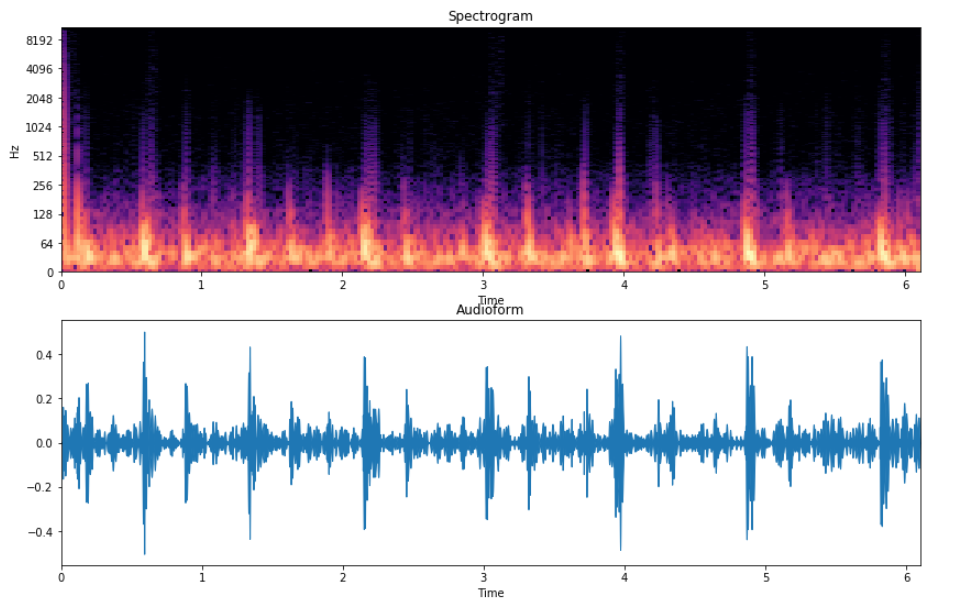

In [ ]:
# ดาวน์โหลดชุดข้อมูลเสียงสิ่งแวดล้อม 50 คลาส esc50dataset (https://www.kaggle.com/datasets/ludovick/esc50dataset)
!pip install opendatasets
import opendatasets as od

# ใช้ 'user/dataset-name' เพื่อเข้าถึงดาวน์โหลด actual dataset path on Kaggle.
od.download('https://www.kaggle.com/datasets/ludovick/esc50dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jirayu.pe
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ludovick/esc50dataset


100%|██████████| 616M/616M [00:04<00:00, 156MB/s]


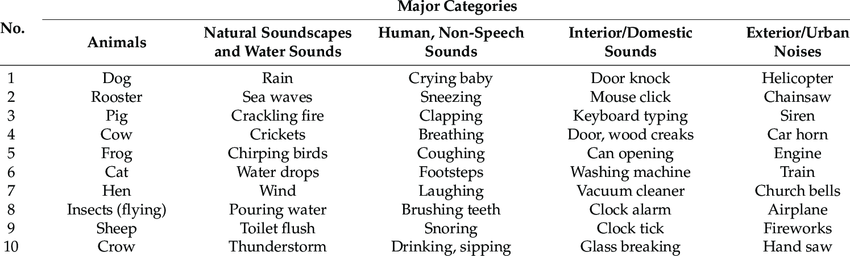

In [ ]:
# สร้างโฟลเดอร์และย้ายชุดข้อมูลเสียที่ดาวน์โหลดไปที่ ./kaggle/input/
!mkdir -p ./kaggle/input/
!mv esc50dataset ./kaggle/input/

In [ ]:
# ทดสอบแสดงตัวอย่างเสียง
# 1-172649-D-40.wav == เสียงเฮลิคอปเตอร์ (Exterior/Urban Noises: Helicopter)
# 1-101336-A-30.wav == เสียงเคาะประตู (Interior/Domestic Sounds: Door knock)

!ls ./kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/audio/1-101336-A-30.wav
audio_data, sampling_rate = librosa.load('./kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/audio/1-101336-A-30.wav', sr=None)
display.Audio(audio_data, rate=sampling_rate)

./kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/audio/1-101336-A-30.wav


In [ ]:
esc50list = [i.split("-")[-1].replace(".wav","") for i in glob("./kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/audio/*.wav")]
label_count = pd.DataFrame.from_dict(dict(Counter(esc50list)), orient="index",columns=["count"]).sort_index(key=lambda x: x.astype(int)).reset_index()

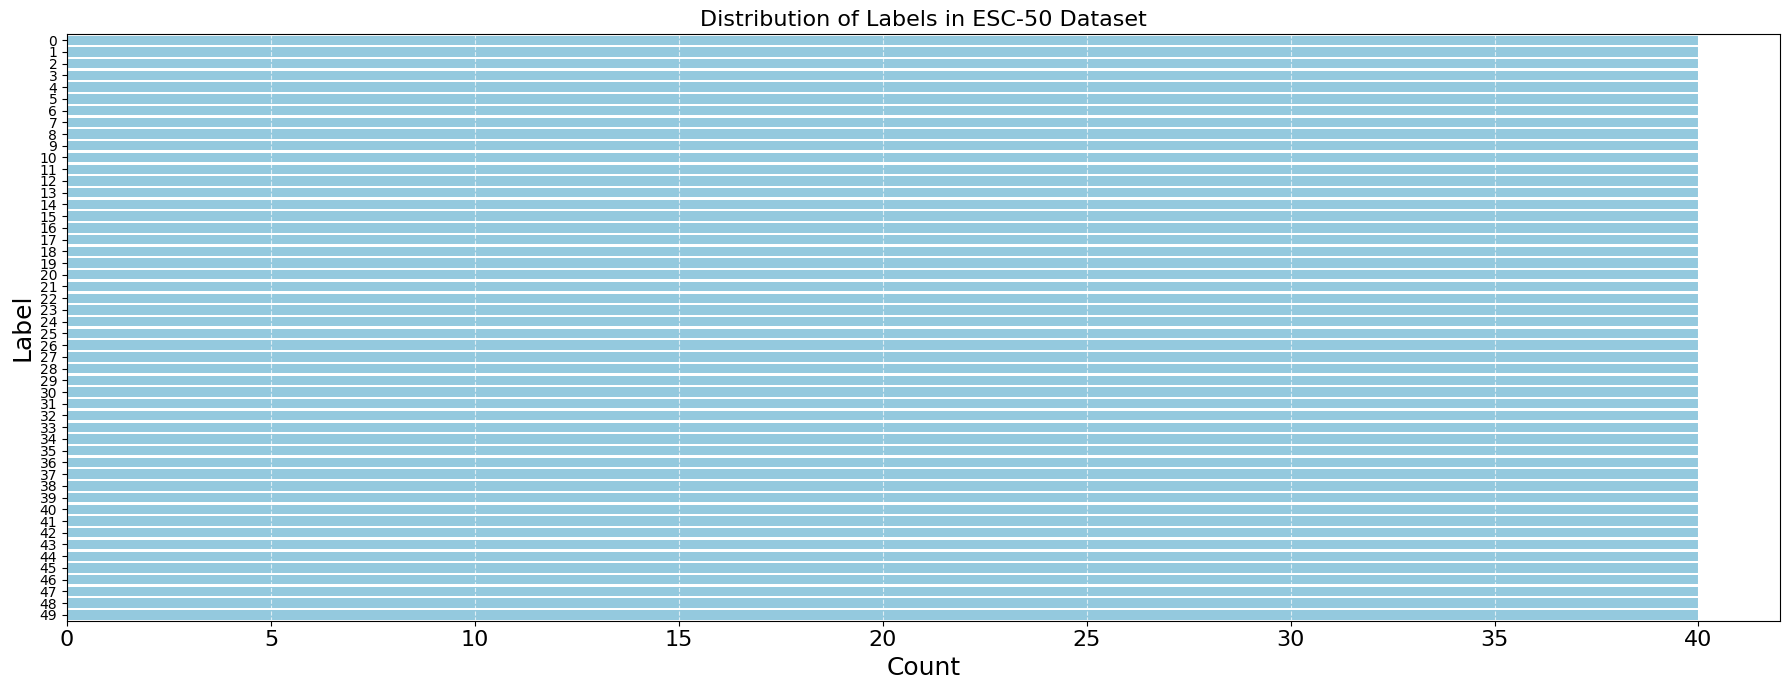

In [ ]:
plt.figure(figsize=(18, 7))
sns.barplot(data=label_count,x="count",y = "index", color="skyblue")


plt.title('Distribution of Labels in ESC-50 Dataset', fontsize=16)
plt.xlabel('Count', fontsize=18)
plt.ylabel('Label', fontsize=18)
plt.grid(axis='x', linestyle='--', alpha=0.7,color="white")
plt.xticks(fontsize=16)
plt.tight_layout()
plt.show()

ชุดข้อมูลสมดุล มีตัวอย่างคลาส คลาสละ 40 ตัวอย่างเท่ากันจาก 50 คลาสสภาพแวดล้อม <hr>

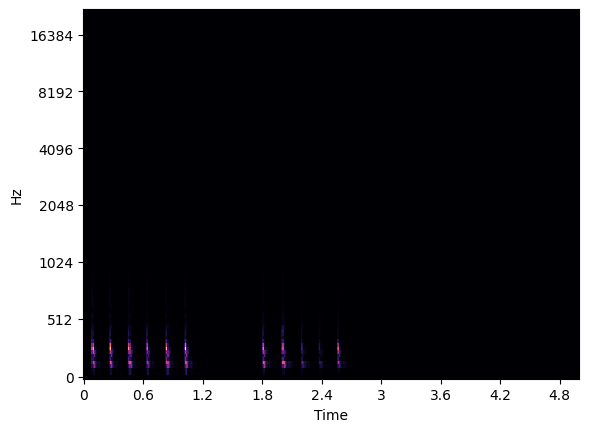

In [ ]:
sample_data, sr = librosa.load("./kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/audio/1-101336-A-30.wav", sr=None)
spectrogram = librosa.feature.melspectrogram(y=sample_data, sr=sr)
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel');

ภาพ Spectrogram ไม่ชัด ด้วยที่ว่าฟังก์ชั่นดั้งเดิมแปลงเป็น Power spectrogram เพื่อให้แอพพลิจูดชัดขึ้นการใช้ Log-power spectrogram จะช่วยให้คลื่นแอมพลิจูดชัดมากขึ้นตามตัวอย่าง
\
ตัวอย่างฟังก์ชันการแปลง power to db (https://librosa.org/doc/main/generated/librosa.power_to_db.html)

\
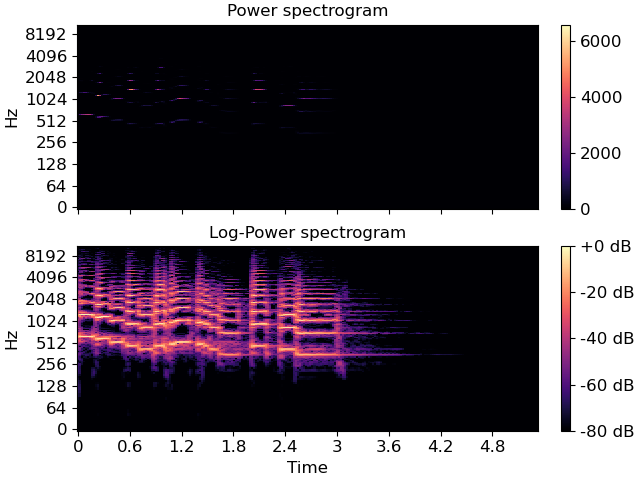

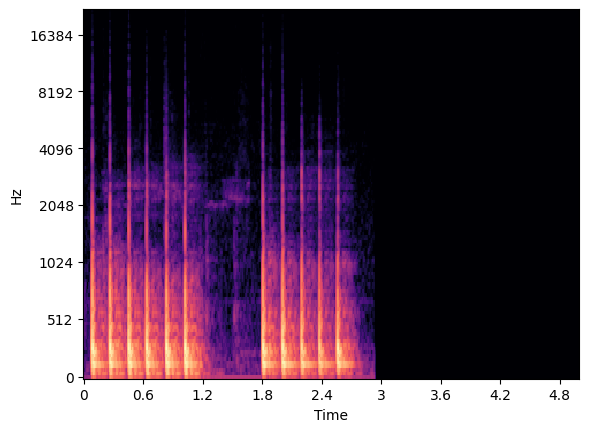

In [ ]:
sample_data, sr = librosa.load("./kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/audio/1-101336-A-30.wav", sr=None)
spectrogram = librosa.feature.melspectrogram(y=sample_data, sr=sr)
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel');

In [ ]:
files = glob("./kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/audio/*.wav")
len(files)

2000

In [ ]:
def precompute_spectograms(files, dpi=50):
    output_dir = "./kaggle/working/mel_spectograms"
    os.makedirs(output_dir, exist_ok=True)
    for file in files:
        output_path = os.path.join(output_dir, f"{dpi}-{os.path.basename(file)}.png")
        if os.path.exists(output_path):
            continue
        audio_tensor, sample_rate = librosa.load(file,sr=None)
        spectogram = librosa.feature.melspectrogram(y=audio_tensor,sr=sample_rate)
        log_spectogram = librosa.power_to_db(spectogram, ref=np.max)
        librosa.display.specshow(log_spectogram,sr=sample_rate, x_axis="time", y_axis="mel")
        plt.gcf().savefig(output_path, dpi=dpi)


KeyboardInterrupt: 

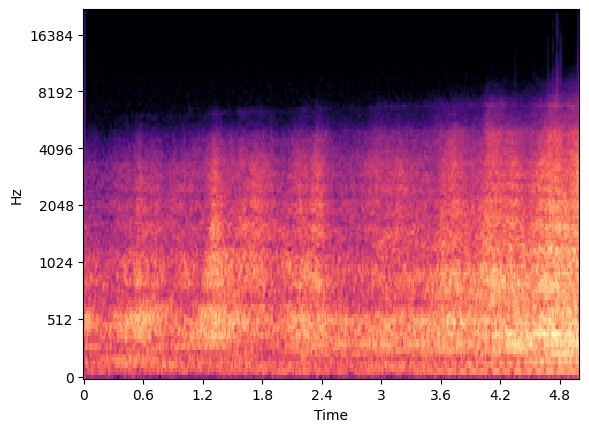

In [ ]:
# Option1: เตรียมข้อมูลเสียง (*.wav) ให้กลายเป็นไฟล์คลื่นเสียง spectrogram เป็นภาพ (*.png) ที่สามารถประมวลผลด้วยโมเดล CNNs ได้
precompute_spectograms(files,dpi=50)

### ดาวน์โหลดข้อมูลที่แปลงเป็นภาพ spectrogram เรียบร้อยแล้ว โดยข้ามขั้นตอนแปลง audio-to-image ก่อนหน้า

In [ ]:
# Option2: ดาวน์โหลดข้อมูลภาพ spectrogram ที่แปลงแล้วพร้อมใช้ในการเรียน CNNs

# ดาวน์โหลดชุดข้อมูลเสียงสิ่งแวดล้อม 50 คลาส esc50dataset ที่แปลงเป็นภาพ spectrogram แล้ว (https://www.kaggle.com/datasets/halemogpa/mel-spectogram-of-esc-50-audio-dataset/data)
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/halemogpa/mel-spectogram-of-esc-50-audio-dataset/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jirayu.pe
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/halemogpa/mel-spectogram-of-esc-50-audio-dataset


100%|██████████| 118M/118M [00:00<00:00, 969MB/s] 

In [ ]:
# สร้าง /working/ folder ใช้เก็บภาพ spectrogram คล้ายกับการ preprocess ที่เก็บภาพใน /working/ folder เช่นกัน

!mkdir -p ./kaggle/working/ # ในกรณีที่ข้ามการทำ preprocess audio-to-spectrogram image
!mv ./mel-spectogram-of-esc-50-audio-dataset ./kaggle/working/mel_spectograms/

In [ ]:
# จำนวนข้อมูล spectrogram ที่แปลงแล้วจาก audio (2000 ไฟล์เสียง)
pngfiles = glob("./kaggle/working/mel_spectograms/*.png")
len(pngfiles)

2000

In [ ]:
# Optional: งก์ชั่นเพิ่มภาพ spectrogram (Augmentation) เพิ่มความหลากหลายให้โมเดลรับรู้มากขึ้น

class specAugment(object):
    def __init__(self, time_mask=10, freq_mask=10,noise_factor=0.010):
        self.time_mask = T.TimeMasking(time_mask_param=time_mask, p=0.7)
        self.freq_mask = T.FrequencyMasking(freq_mask_param=freq_mask)
        self.noise_factor = noise_factor
    def __call__(self,spectogram):
        augmented_spec = self.time_mask(spectogram)
        augmented_spec = self.time_mask(spectogram)
        augmented_spec = self.freq_mask(augmented_spec)
        augmented_spec = self.freq_mask(augmented_spec)
        noise = self.noise_factor * torch.randn_like(augmented_spec)
        augmented_spec += noise
        return augmented_spec

Time masking from torchaudio.transform(...)
\
ตัวอย่างฟังก์ชันการแปลงข้อมูลสัญญาณผ่าน torchaudio (https://docs.pytorch.org/audio/main/transforms.html)

\
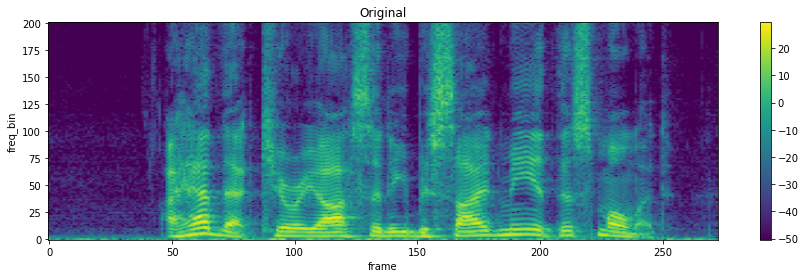


\
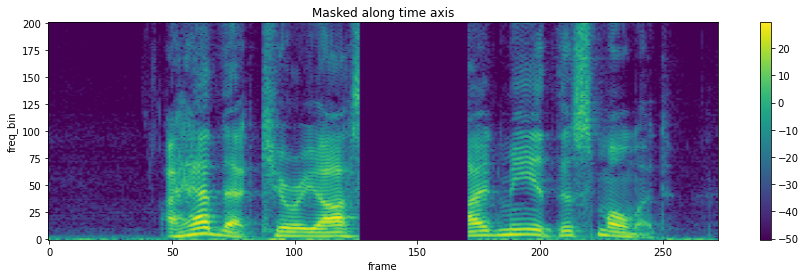

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    # specAugment(time_mask=65,freq_mask=65),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class SpecDataset(Dataset):
    def __init__(self, files=pngfiles, set_type="train"):
        self.paths = files
        self.labels = None
        if set_type=="train": # เตรียมชุดฝึกฝน
            self.transform = train_transform
            self.paths = [file for file in self.paths if not ('-4-' in file or '-5-' in file)]
        elif set_type =="valid":  # ชุดทดสอบ
            self.transform = valid_transform
            self.paths = [file for file in self.paths if '-4-' in file]
        else:
            self.transform = valid_transform
            self.paths = [file for file in self.paths if '-5-' in file]

        self.labels = [int(label.split("-")[-1].replace(".wav.png","")) for label in self.paths]



    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        img_path = self.paths[index]
        label = self.labels[index]
        img = Image.open(img_path)
        img = img.convert("RGB")

        img = self.transform(img)

        return img, torch.tensor(label)



In [ ]:
train_dataset = SpecDataset(files=pngfiles, set_type="train")
valid_dataset = SpecDataset(files=pngfiles, set_type="valid")
test_dataset = SpecDataset(files=pngfiles, set_type="test")

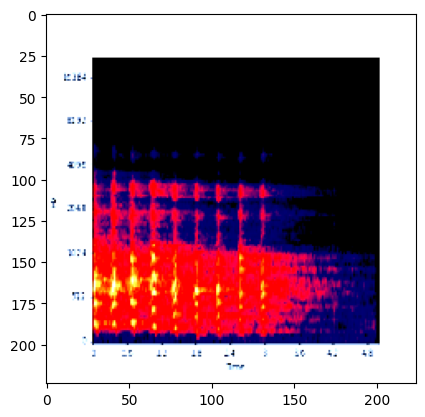

tensor(26)


In [ ]:
image,label = train_dataset[0]
plt.imshow(image.permute(1,2,0))
plt.show()
print(label)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# vvvvvvvvvvvvvvvv
model = 'simple_cnn'
lr = 0.01
# ^^^^^^^^^^^^^^^^

if model == 'simple_cnn':
    # โมเดล Simple CNNs อย่างง่าย
    lr = 0.001
    class SimpleCNN(nn.Module):
        def __init__(self, num_classes=50):
            super(SimpleCNN, self).__init__()
            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
            self.relu1 = nn.ReLU()
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
            self.relu2 = nn.ReLU()
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.relu3 = nn.ReLU()
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

            # Input size is 224x224, หลังจากผ่านไป 3 conv = 224x224//2 --> 112x112//2 --> 56x56//2 --> 28x28
            # channels เท่ากับ 64 จาก conv3 ล่าสุด
            self.fc = nn.Linear(64 * (224 // 8) * (224 // 8), num_classes)

        def forward(self, x):
            x = self.pool1(self.relu1(self.conv1(x)))
            x = self.pool2(self.relu2(self.conv2(x)))
            x = self.pool3(self.relu3(self.conv3(x)))
            x = x.view(-1, 64 * (224 // 8) * (224 // 8))
            x = self.fc(x)
            return x

    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    criterion = nn.CrossEntropyLoss()


elif model == 'resnet':
    # โมเดล pretrained ResNet-50
    def initialize_model():
        resnet = models.resnet50(weights = ResNet50_Weights.DEFAULT) # output size = 1000
        for name, param in resnet.named_parameters():
            if ("bn" not in name):
                param.requires_grad=False
        unfreeze_layers = [resnet.layer3, resnet.layer4]
        for layer in unfreeze_layers:
            for param in layer.parameters():
                param.requires_grad = True
        resnet.fc = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.BatchNorm1d(512),
            nn.Linear(512, 50)
        )
        return resnet

    model = initialize_model().to(device)
    optimizer = optim.Adam([
        {"params":model.layer3.parameters(), "lr":lr/9},
        {"params":model.layer4.parameters(), "lr":lr/3},
        {"params":model.fc.parameters(), "lr":lr}
    ], lr = lr/10)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)
    criterion = nn.CrossEntropyLoss()


In [ ]:
def train(epochs, model, optimizer, criterion, train_iterator, valid_iterator,patience=3, model_dir="best_model", finetune_param=True):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    best_score = float("inf")
    tolerance = 0
    os.makedirs(model_dir, exist_ok=True)

    for epoch in range(1,epochs+1):
        train_loss=0.0
        valid_loss=0.0
        train_correct, train_total = 0,0
        valid_correct, valid_total = 0,0
        model.train()
        for batch_idx, (image,label) in enumerate(train_iterator):
            optimizer.zero_grad()
            image,label = image.to(device), label.to(device)
            outputs = model(image)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == label).sum().item()
            train_total += label.size(0)


        train_loss /= len(train_iterator)
        train_accuracy = train_correct / train_total


        model.eval()
        with torch.no_grad():
            for batch_idx, (image,label) in enumerate(valid_iterator):
                image,label = image.to(device), label.to(device)
                outputs = model(image)
                loss = criterion(outputs, label)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                valid_correct += (predicted == label).sum().item()
                valid_total += label.size(0)

        valid_loss /= len(valid_iterator)
        valid_accuracy = valid_correct / valid_total
        print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        scheduler.step()

        if epoch%6==0:
            print()
            if finetune_param is True:
              current_lr = optimizer.param_groups[2]["lr"]
            else:
              current_lr = optimizer.param_groups[0]["lr"]
            print(f"Learning Rate after epoch {epoch}: {current_lr:.6f}")
            print()


        if (valid_loss+0.0001)< best_score:
            best_score = valid_loss
            model_save_path = os.path.join(model_dir, f"best_model_epoch{epoch}_loss_{round(best_score,4)}.pth")
            torch.save(model.state_dict(),model_save_path)
            print(f"Model saved at epoch {epoch} with validation loss {valid_loss:.4f} as '{model_save_path}'")
            tolerance = 0
        else:
            tolerance += 1
            if tolerance>=patience:
                print(f"Early Stopping at epoch {epoch}")
                break

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [ ]:
train_losses, valid_losses, train_accuracies, valid_accuracies = (
    train(50,model,optimizer,criterion,train_loader,valid_loader, 5, model_dir="best_model", finetune_param=False)
)

Epoch: 1, Train Loss: 4.1705, Train Accuracy: 0.0600, Valid Loss: 3.4438, Valid Accuracy: 0.0900
Model saved at epoch 1 with validation loss 3.4438 as 'best_model/best_model_epoch1_loss_3.4438.pth'
Epoch: 2, Train Loss: 3.2094, Train Accuracy: 0.1592, Valid Loss: 3.1786, Valid Accuracy: 0.1800
Model saved at epoch 2 with validation loss 3.1786 as 'best_model/best_model_epoch2_loss_3.1786.pth'
Epoch: 3, Train Loss: 2.7712, Train Accuracy: 0.2575, Valid Loss: 2.8971, Valid Accuracy: 0.2325
Model saved at epoch 3 with validation loss 2.8971 as 'best_model/best_model_epoch3_loss_2.8971.pth'
Epoch: 4, Train Loss: 2.2897, Train Accuracy: 0.3842, Valid Loss: 2.7217, Valid Accuracy: 0.2975
Model saved at epoch 4 with validation loss 2.7217 as 'best_model/best_model_epoch4_loss_2.7217.pth'
Epoch: 5, Train Loss: 1.8764, Train Accuracy: 0.4925, Valid Loss: 2.6466, Valid Accuracy: 0.3075
Model saved at epoch 5 with validation loss 2.6466 as 'best_model/best_model_epoch5_loss_2.6466.pth'
Epoch: 6, 

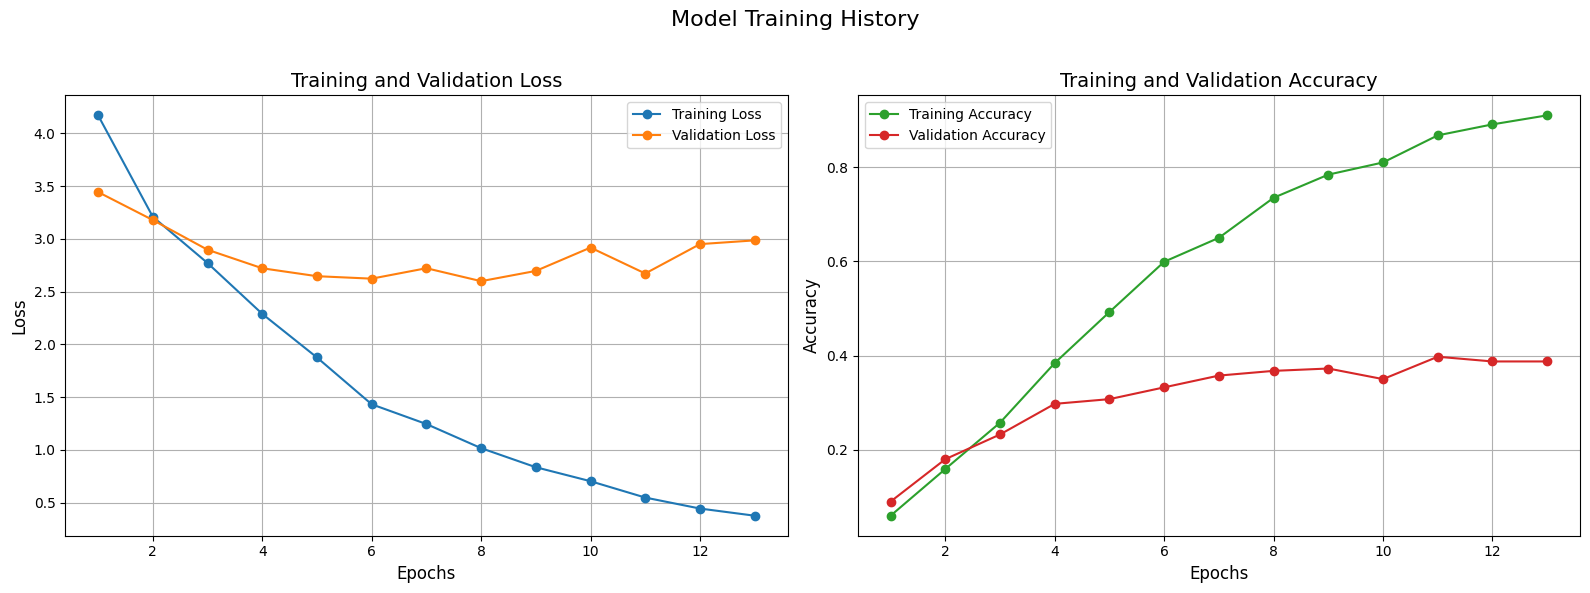

In [ ]:
def plot_training_history(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(epochs, train_losses, 'o-', label='Training Loss', color='tab:blue')
    ax1.plot(epochs, valid_losses, 'o-', label='Validation Loss', color='tab:orange')
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(loc='best')
    ax1.grid(True)

    ax2.plot(epochs, train_accuracies, 'o-', label='Training Accuracy', color='tab:green')
    ax2.plot(epochs, valid_accuracies, 'o-', label='Validation Accuracy', color='tab:red')
    ax2.set_title('Training and Validation Accuracy', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(loc='best')
    ax2.grid(True)

    plt.suptitle('Model Training History', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_training_history(train_losses, valid_losses, train_accuracies, valid_accuracies)

In [ ]:
to_delete_models=  glob("./best_model/*")
# print(len(to_delete_models))
# not_to_delete = ["./kaggle/working/best_model/best_model_epoch29_loss_0.5548.pth",
#                  "./kaggle/working/best_model/best_model_epoch17_loss_0.5162.pth",
#                  "./kaggle/working/best_model/best_model_epoch21_loss_0.5306.pth",
#                  "./kaggle/working/best_model/best_model_epoch22_loss_0.6527.pth"
#                 ]
# to_delete_models = [i for i in to_delete_models if i not in not_to_delete]
# len(to_delete_models)
# for i in to_delete_models:
#     os.remove(i)

In [ ]:
def load_models(model, model_path, device):
    model_path = model_path
    model.load_state_dict(torch.load(model_path,map_location=device))
    model.eval()
    return model.to(device)

In [ ]:
model_test = SimpleCNN()
model_dir = "./best_model/best_model_epoch8_loss_2.5994.pth"

In [ ]:
def evaluate_model_on_test_set(model_test, model_dir, test_loader, criterion):
    model = load_models(model_test, model_dir, device=device)

    test_loss = 0.0
    test_correct, test_total = 0, 0
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for batch_idx, (image, label) in enumerate(test_loader):
            image, label = image.to(device), label.to(device)
            outputs = model(image)
            loss = criterion(outputs, label)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == label).sum().item()
            test_total += label.size(0)
#             all_preds_proba
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = test_correct / test_total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_accuracy, all_preds, all_labels,

In [ ]:
test_accuracy,preds, labels = evaluate_model_on_test_set(model_test, model_dir, test_loader,criterion)

Test Loss: 2.6093, Test Accuracy: 0.3525


In [ ]:
df = pd.read_csv("./kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/meta/esc50.csv")
df = df[["target","category"]]
ind_to_label=dict()
for row in df.iterrows():
    ind_to_label[row[1][0]] = row[1][1]

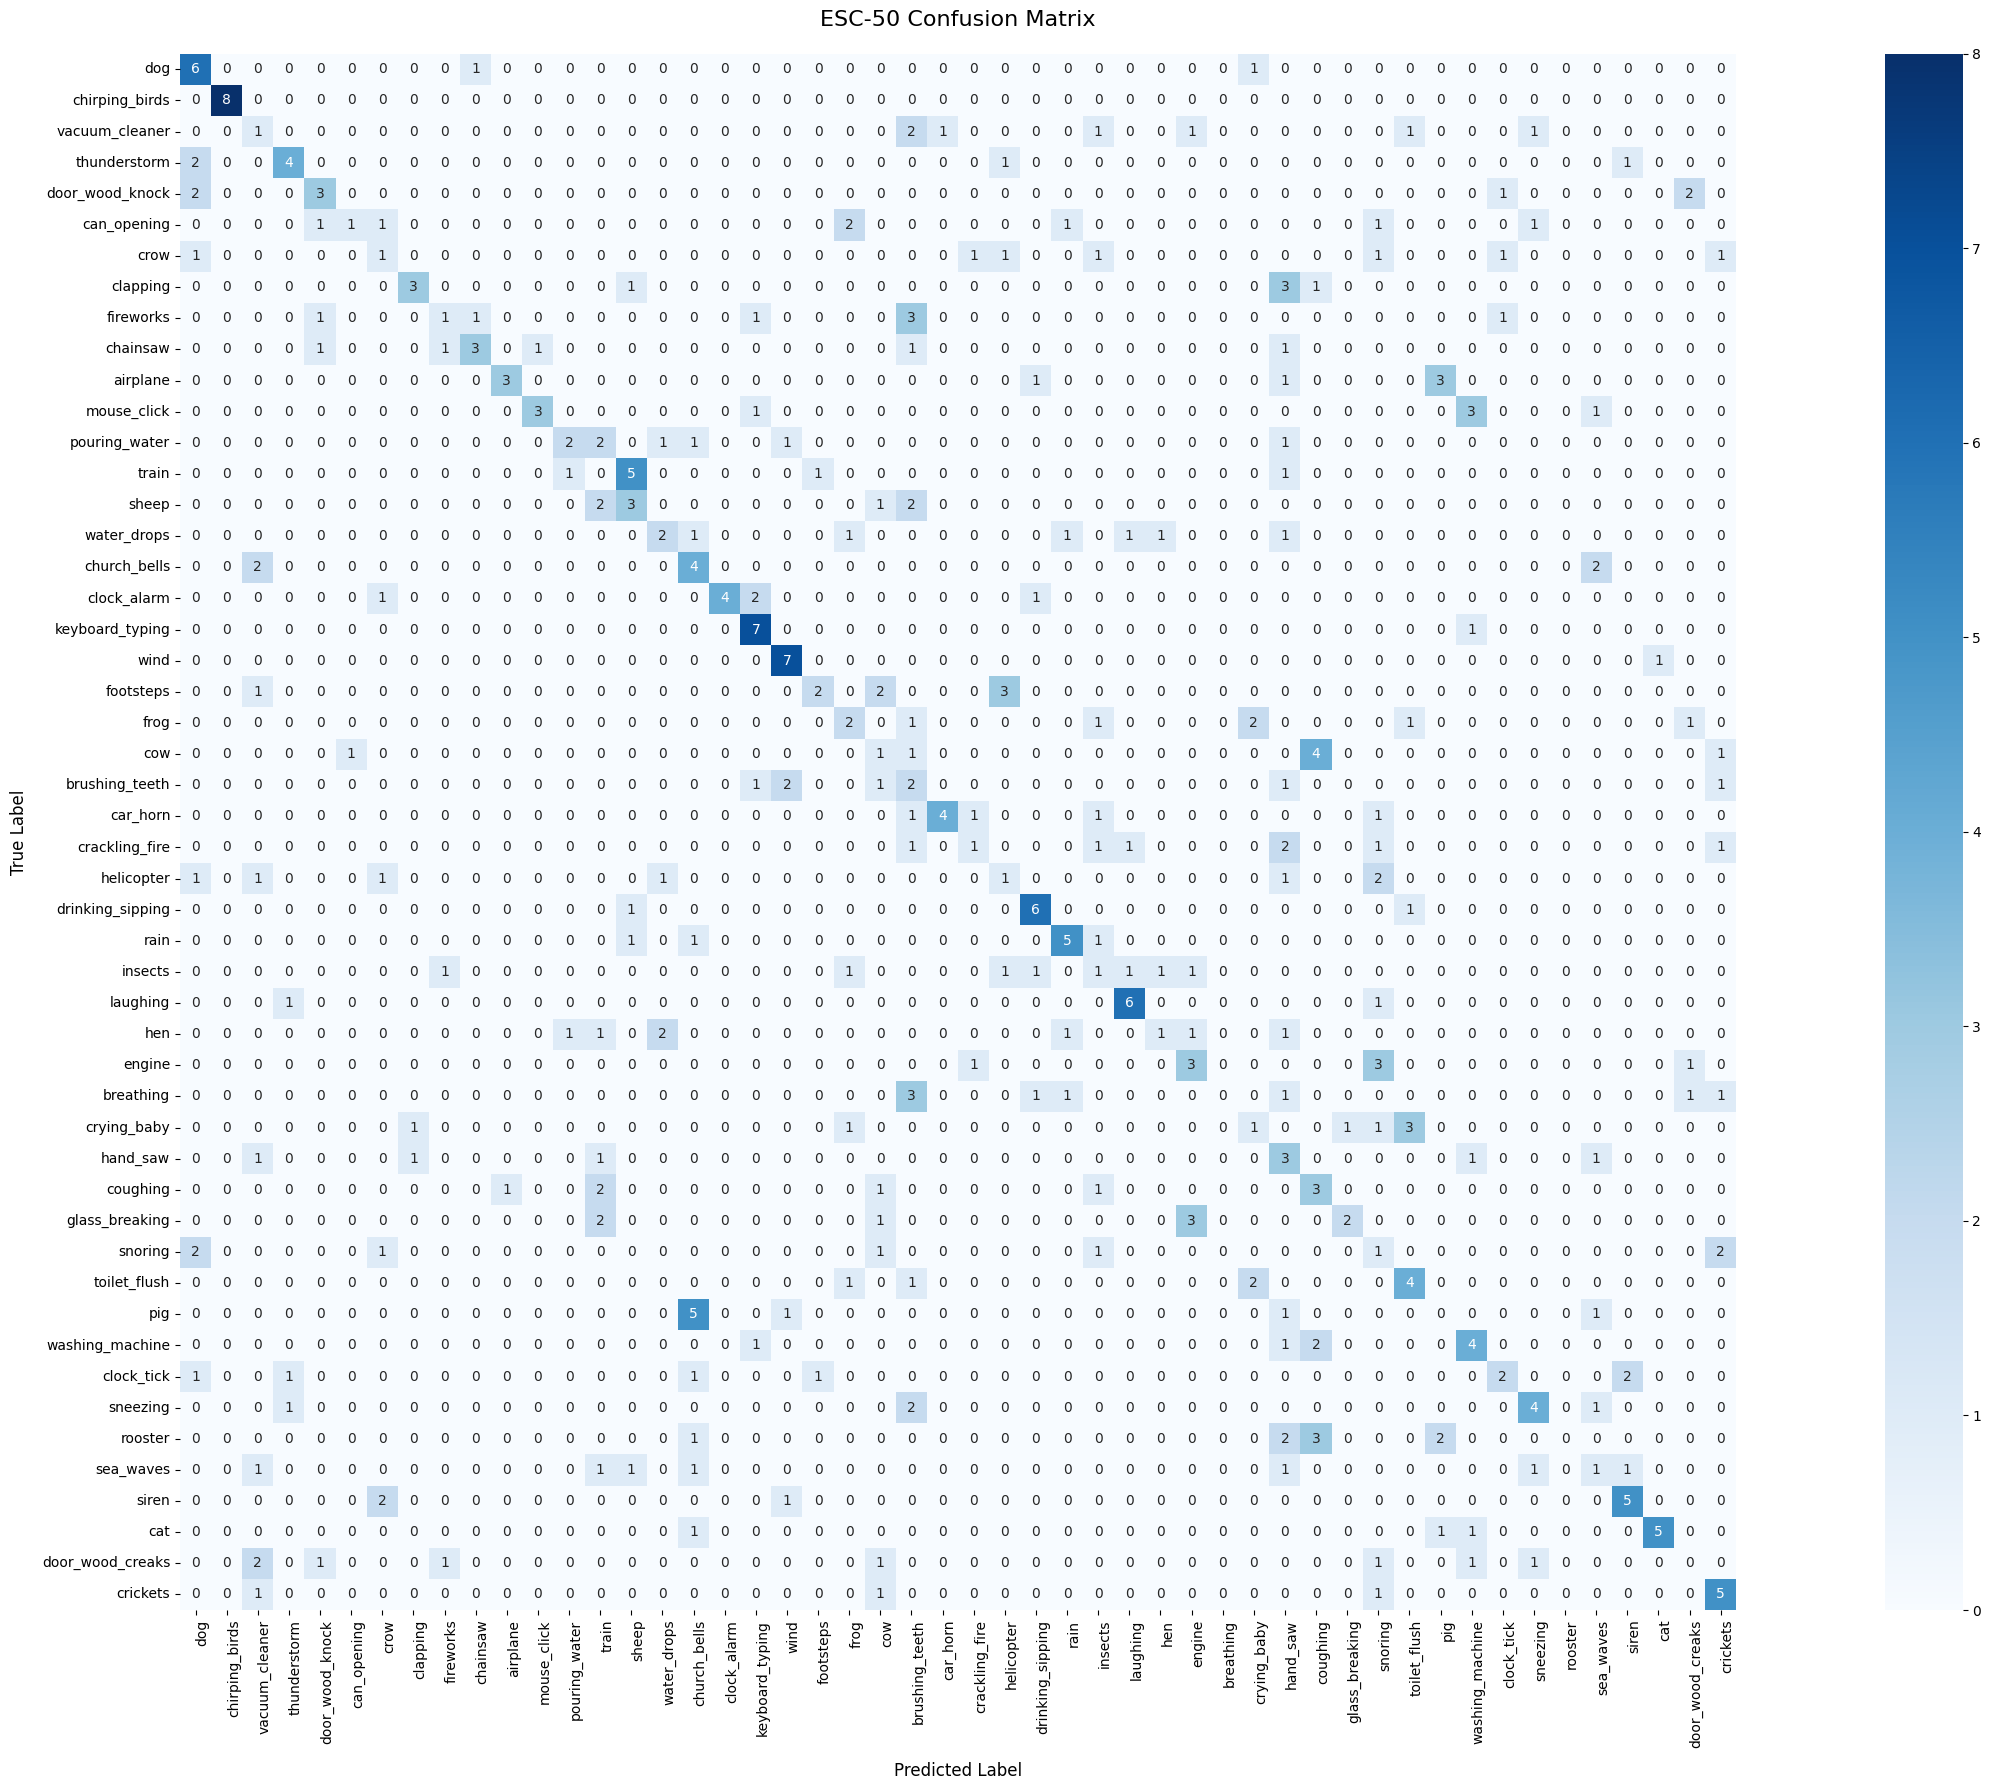

In [ ]:
def plot_enhanced_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(30, 18))
    cmap = sns.color_palette("Blues", as_cmap=True)
    sns.heatmap(cm, annot=True, fmt='d',cmap=cmap, cbar=True, square=True,
                xticklabels=class_names, yticklabels=class_names, ax=ax)

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor", fontsize=10)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=12, labelpad=10)
    ax.set_ylabel('True Label', fontsize=12, labelpad=10)
    ax.set_title(title, pad=20, fontsize=16)
    plt.tight_layout()
    return fig

fig = plot_enhanced_confusion_matrix(labels, preds, list(ind_to_label.values()), title='ESC-50 Confusion Matrix')
plt.show()


----
# แบบฝึกหัด

1. จงฝึกและทดสอบโมเดล CNNs ใหม่จาก "SimpleCNN" function ที่สามารถจดจำการเรียนรู้ของข้อมูลเสียง ESC-50 ได้และสามารถจำแนกได้ความแม่นยำข้อมูลทดสอบ (Validation and Testing dataset) เกิน 60%